Animating oil dispersion on the Salish Sea Atlantis grid. Original code written by Bec Gordon & Javier Porobic, CSIRO, modified to create an animated GIF

In [24]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [25]:
# salish sea atlantis box shapefile.
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df = gpd.read_file(shapefile_name)
data_df = data_df.sort_values(by=['BOX_ID'])
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]


In [26]:
# Reading in the file generated by Ocean Parcels

scenario = '5b TurnPoint Dilbit'
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/5b_TurnPoint_Control/outputSalishSea.nc"
data_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/5b_TurnPoint_BranchCode/outputSalishSea.nc"

# data
control = xr.open_dataset(str(control_file), decode_cf=True)
data = xr.open_dataset(str(data_file), decode_cf=True)

# time
control_time = np.ma.filled(control.variables['t'], np.nan)
oiled_time = np.ma.filled(data.variables['t'], np.nan)
num_steps = oiled_time.shape[0]

In [27]:
def box_total(data, control, species):
    
    data_all = np.ma.filled(data.variables[species][:,:,:], np.nan)
    data_all_depths = data_all.sum(axis=2)
    
    control_all = np.ma.filled(control.variables[species][:,:,:], np.nan)
    control_all_depths = control_all.sum(axis=2)

    return data_all_depths, control_all_depths

def model_total(data, control, species):
    
    data_all = np.ma.filled(data.variables[species], np.nan)
    data_all_depths = data_all.sum(axis=2)
    data_all_boxes = data_all_depths.sum(axis=1)
    
    control_all = np.ma.filled(control.variables[species], np.nan)
    control_all_depths = control_all.sum(axis=2)
    control_all_boxes = control_all_depths.sum(axis=1)

    return data_all_boxes, control_all_boxes

def cohort_total_perbox(data, species_name, numCohorts):

    numbers = np.ma.zeros((data.variables[species_name + '1_Nums'].shape),dtype = np.int32)
    structuralN = np.ma.zeros((data.variables[species_name + '1_Nums'].shape),dtype = np.int32)
    reservedN = np.ma.zeros((data.variables[species_name + '1_Nums'].shape),dtype = np.int32)

    for cohort in range (1, numCohorts+1):

        species = species_name + str(cohort)
        
        numbers = numbers + np.ma.filled(data.variables[species + '_Nums'][:,:,:], np.nan)
        structuralN = structuralN + np.ma.filled(data.variables[species +'_StructN'][:,:,:], np.nan)
        reservedN = reservedN + np.ma.filled(data.variables[species +'_ResN'][:,:,:], np.nan)

    numbers = numbers.sum(axis=2)
    structuralN = structuralN.sum(axis=2)
    reservedN = reservedN.sum(axis=2)
    
    return numbers, structuralN, reservedN 


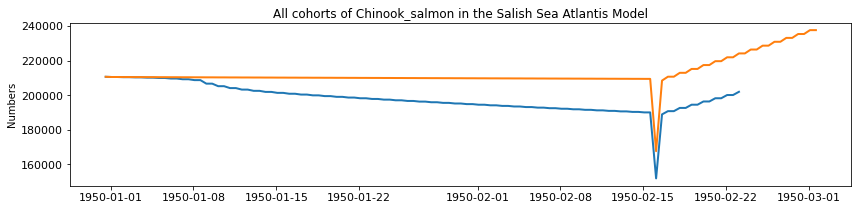

In [28]:
# Age-structured species
species = 'Chinook_salmon'
numCohorts = 5

num_oiled, sN_oiled, rN_oiled = cohort_total_perbox(data, species, numCohorts)
num_control, sN_control, rN_control = cohort_total_perbox(control, species, numCohorts)

model_numbers_oiled = num_oiled.sum(axis=1)
model_numbers_control = num_control.sum(axis=1)

label_size = 11
font_size = 12
line_width = 2

fig, ax = plt.subplots(figsize = (14,3))
ax.plot(oiled_time, model_numbers_oiled, control_time, model_numbers_control, linewidth = line_width)
ax.set_title('All cohorts of ' + species + ' in the Salish Sea Atlantis Model', fontsize = font_size)
ax.set_ylabel('Numbers')
ax.tick_params(labelsize=label_size)

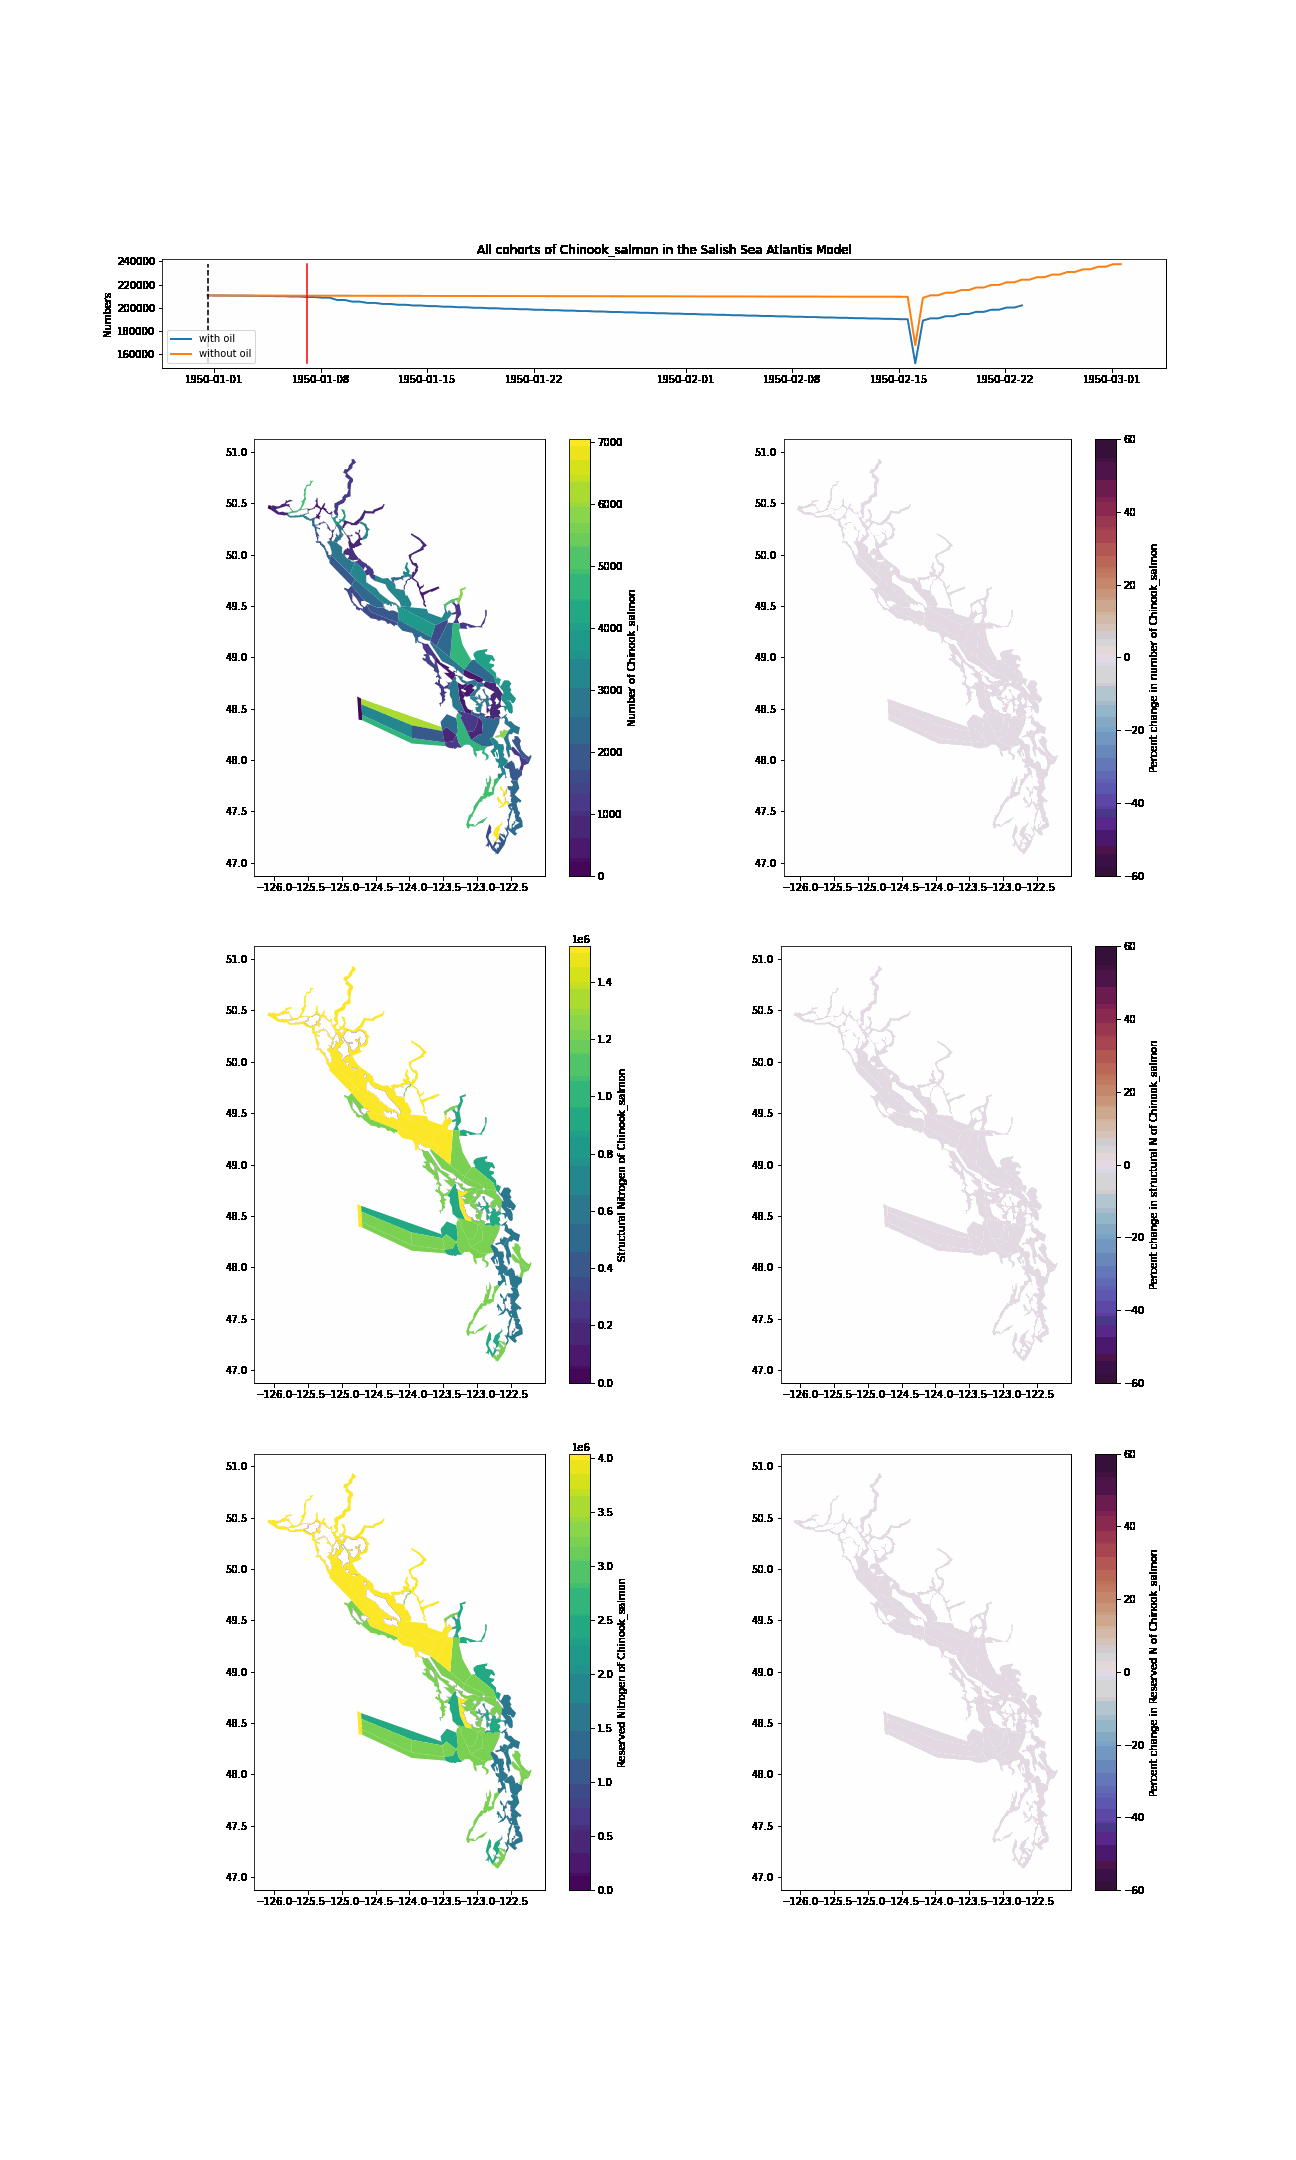

In [29]:
_cmap = cm.twilight_shifted #winter #viridis #Paired
file_names = []

land_df = data_df.loc[land_boxes]

n_min = np.min(model_numbers_oiled)
n_max = np.max(model_numbers_control)

for time_index in range(0, num_steps):

    ts_date = pd.to_datetime(str(oiled_time[time_index]))
    spill_date = pd.to_datetime(str(oiled_time[13]))

    num_oil = num_oiled[time_index][:]
    num_con = num_control[time_index][:]
    sN_oil = sN_oiled[time_index][:]
    sN_con = sN_control[time_index][:]
    rN_oil = rN_oiled[time_index][:]
    rN_con = rN_control[time_index][:]
    
    data_df['num_oiled'] = num_oil
    data_df['num_control'] = (num_oil - num_con) / num_con * 100
    data_df['struct_N_oiled'] = sN_oil
    data_df['struct_N_control'] = (sN_oil - sN_con) / sN_con * 100
    data_df['reserv_N_oiled'] = rN_oil
    data_df['reserv_N_control'] = (rN_oil - rN_con) / rN_con * 100

    data_df.loc[land_boxes, 'num_oiled'] = 0
    data_df.loc[land_boxes, 'struct_N_oiled'] = 0
    data_df.loc[land_boxes, 'reserv_N_oiled'] = 0
 
    fig = plt.figure(figsize=(18, 30))
    gs = plt.GridSpec(4, 2, wspace=0.1, hspace=0.2, width_ratios=[1, 1], height_ratios=[0.25, 1, 1, 1])

    # Numbers
    ax_ts = fig.add_subplot(gs[0, :])
    ax_ts.plot(oiled_time, model_numbers_oiled, control_time, model_numbers_control, linewidth = line_width)
    ax_ts.plot([ts_date, ts_date], [n_min, n_max], 'k--')
    ax_ts.plot([spill_date, spill_date], [n_min, n_max], 'r')
    ax_ts.set_title('All cohorts of ' + species + ' in the Salish Sea Atlantis Model', fontsize = font_size)
    ax_ts.set_ylabel('Numbers')
    ax_ts.legend(('with oil', 'without oil'), loc='lower left')


    ax = fig.add_subplot(gs[1, 0])
    ax = data_df.plot(column='num_oiled', vmin=np.min(num_oiled[-1]), vmax=np.max(num_control[-1])/2, ax=ax, legend=True,
    legend_kwds={'label': "Number of " + species
                },)  
    #ax.set_title(oiled_time[time_index], fontsize = font_size)  
    land_df.plot(ax=ax, color='white')   

    ax = fig.add_subplot(gs[1, 1])
    ax = data_df.plot(column='num_control', cmap=_cmap, vmin=-60, vmax=60, ax=ax, legend=True,
    legend_kwds={'label': "Percent change in number of " + species
                 },)
    #ax.set_title(oiled_time[time_index], fontsize = font_size)
    land_df.plot(ax=ax, color='white') 

    # Structural nitrogen
    ax = fig.add_subplot(gs[2, 0])
    ax = data_df.plot(column='struct_N_oiled', vmin=np.min(sN_oiled[-1]), vmax=np.max(sN_control[-1]), ax=ax, legend=True,
    legend_kwds={'label': "Structural Nitrogen of " + species
                },)  
    land_df.plot(ax=ax, color='white')   

    ax = fig.add_subplot(gs[2, 1])
    ax = data_df.plot(column='struct_N_control', cmap=_cmap, vmin=-60, vmax=60, ax=ax, legend=True,
    legend_kwds={'label': "Percent change in structural N of " + species
                 },)
    land_df.plot(ax=ax, color='white') 

    # Reserved nitrogen
    ax = fig.add_subplot(gs[3, 0])
    ax = data_df.plot(column='reserv_N_oiled', vmin=np.min(rN_oiled[-1]), vmax=np.max(rN_control[-1]), ax=ax, legend=True,
    legend_kwds={'label': "Reserved Nitrogen of " + species
                },)  
    land_df.plot(ax=ax, color='white')   

    ax = fig.add_subplot(gs[3, 1])
    ax = data_df.plot(column='reserv_N_control', cmap=_cmap, vmin=-60, vmax=60, ax=ax, legend=True,
    legend_kwds={'label': "Percent change in Reserved N of " + species
                 },)
    land_df.plot(ax=ax, color='white') 

    #plt.tight_layout()
    plot_name = species + '_time_' + str(time_index).zfill(3) + '.png'
    plt.savefig(plot_name)
    file_names.append(plot_name)
    plt.close()

from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob("*.png")
imgs.sort() 
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)


# Save into loop
anim_name = str(scenario) + '_age-structured_' + species +'.gif'
frames[0].save(anim_name, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

file_name_str = ' '.join(file_names)
os.system('rm ' + file_name_str)

from IPython.display import Image
with open(anim_name,'rb') as anim:
    display(Image(anim.read()))